In [144]:
%load_ext autoreload
%autoreload 3
import math
import numpy as np
import pandas as pd
import utils
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utils.constants import xai_names, selected_uni
from utils.visualization import plot_multiple_images_with_attribution
from utils.shapelet import get_distances_info_gain
from utils.insert_shapelet import get_gt_attr
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [294]:
from tsai.models.FCN import FCN
model_path = '../../PretrainModels/TimeSeriesClassifications/FCN/GunPoint/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()

train_x, test_x, train_y, test_y, enc1 = utils.read_UCR_UEA('GunPoint', None)

test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)
preds = np.load(f'{model_path}/test_preds.npy')

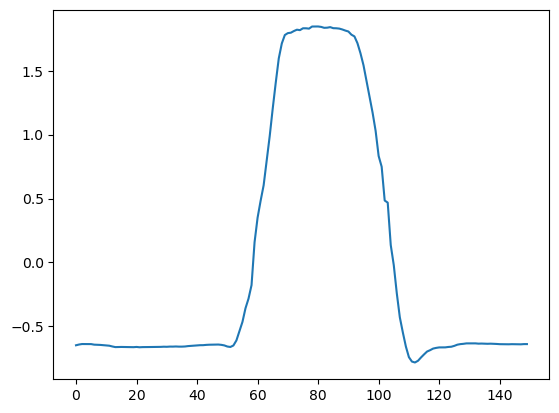

In [295]:
plt.plot(train_x[0][0].flatten())

In [285]:
train_x.shape

(20, 1, 24)

In [263]:
np.where(train_y==1)

(array([ 1,  4,  5,  8,  9, 10, 11, 12, 13, 15, 16, 17, 20, 21, 22, 24, 25,
        26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 45, 48,
        50, 51, 52, 54, 55, 58, 59, 60, 62, 63, 64, 66, 67, 68, 69, 70, 71,
        73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 87, 89, 91, 92, 94, 95, 98,
        99]),)

In [266]:
xai_names

['DeepLift',
 'IntegratedGradients',
 'InputXGradient',
 'Saliency',
 'Lime',
 'Occlusion',
 'KernelShap',
 'GuidedBackprop']

DeepLift


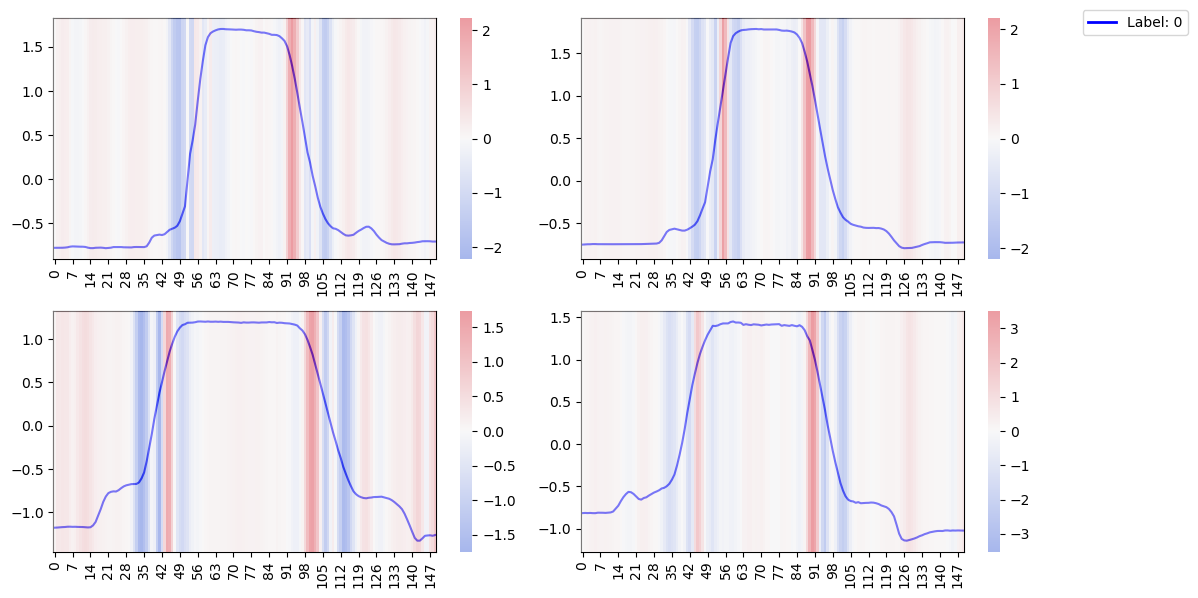

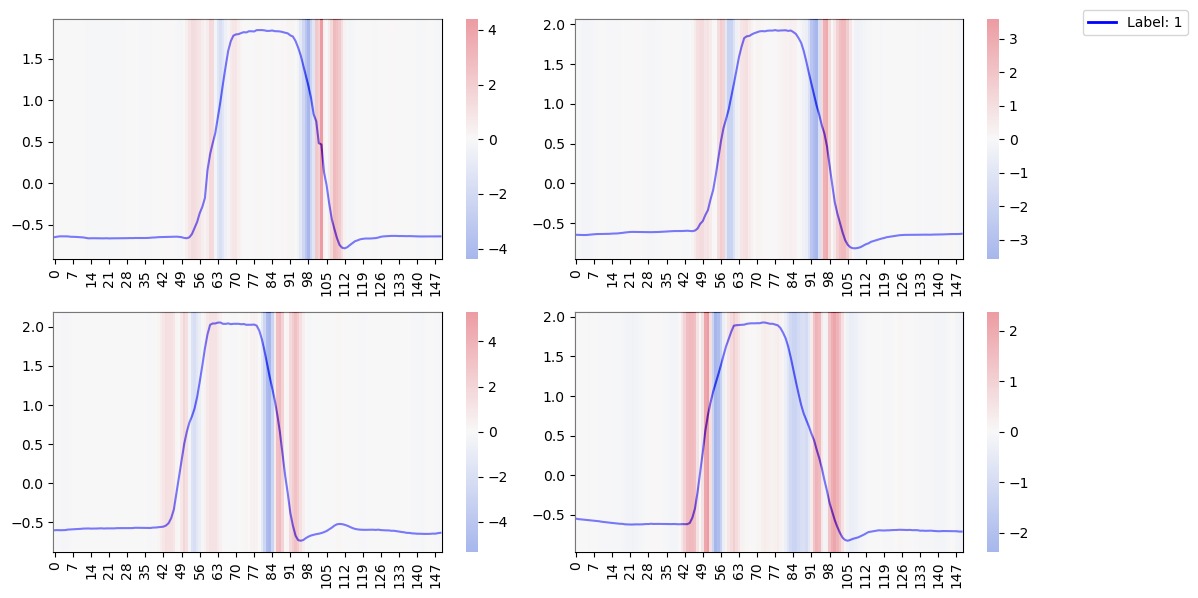

In [296]:
for xai_name in ['DeepLift']:
    print(xai_name)
    # attr_gp, _= get_gt_attr(model,train_x,None,None,
    #                         save_dir=f'attributions/GunPoint/{xai_name}/exp.pkl',
    #                         xai_name=xai_name,target_class=None)


    with open(f'attributions/GunPoint/{xai_name}/exp.pkl', 'rb') as f:
        attr = pickle.load(f)
    attr_gp = attr['attributions']
    plot_multiple_images_with_attribution(train_x[np.where(train_y==0)], train_y[np.where(train_y==0)], 4, (12, 6), 
                                          use_attribution=True,
                                          attributions=attr_gp[np.where(train_y==0)],
                                          normalize_attribution=True,
                                          save_path=None,
                                          test_y = train_y[np.where(train_y==0)],
                                          # shapelet_length=15,
                                          # startings=[[70],[70]]
                                         )
    plot_multiple_images_with_attribution(train_x[np.where(train_y==1)], train_y[np.where(train_y==1)],4,  (12, 6), 
                                          use_attribution=True,
                                          attributions=attr_gp[np.where(train_y==1)],
                                          normalize_attribution=True,
                                          save_path=None,
                                          test_y = train_y[np.where(train_y==1)],
                                          # shapelet_length=13,
                                          # startings=[[100],[100]]
                                         )

In [7]:
with open('attributions/GunPoint/DeepLift/exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

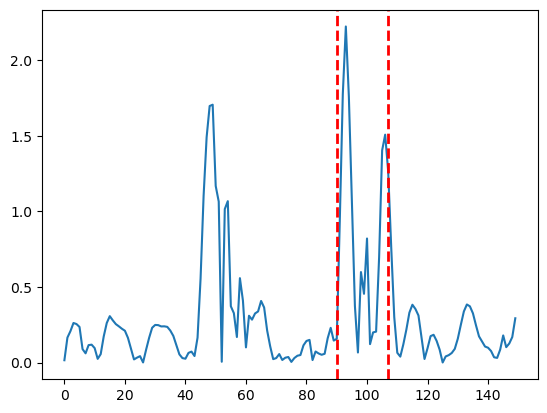

In [8]:
plt.plot(np.abs(attr_gp[2]))
plt.axvline(x=90, color='r', linestyle='--', linewidth=2)
plt.axvline(x=107, color='r', linestyle='--', linewidth=2)

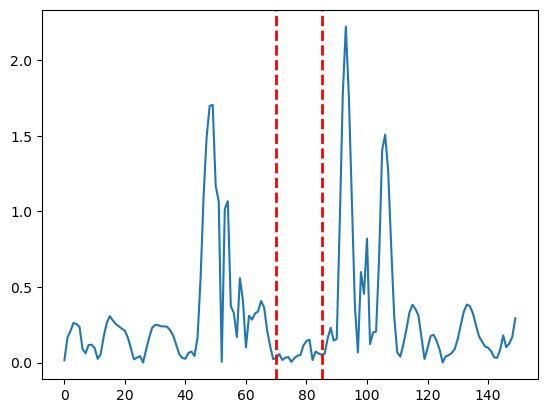

In [123]:
plt.plot(np.abs(attr_gp[2]))
plt.axvline(x=70, color='r', linestyle='--', linewidth=2)
plt.axvline(x=85, color='r', linestyle='--', linewidth=2)

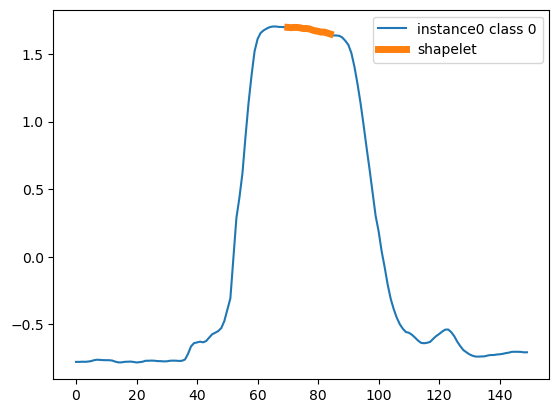

In [188]:
plt.plot(train_x[2].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(70,85),train_x[2,:,70:85].flatten(),
         linewidth=5,label='shapelet')
plt.legend()

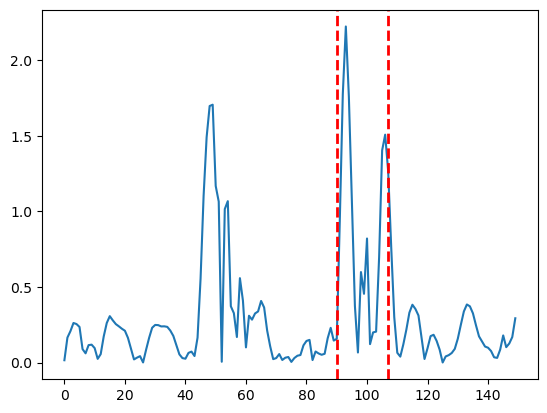

In [9]:
plt.plot(np.abs(attr_gp[2]))
plt.axvline(x=90, color='r', linestyle='--', linewidth=2)
plt.axvline(x=107, color='r', linestyle='--', linewidth=2)

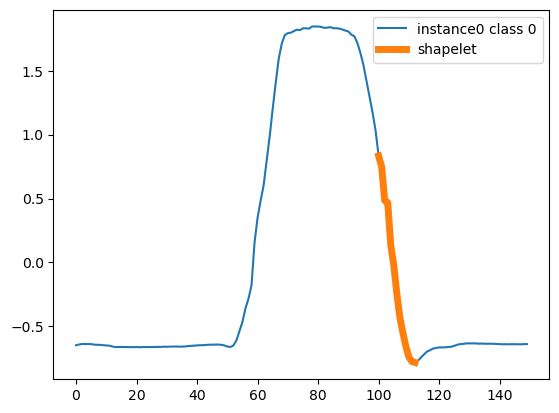

In [244]:
plt.plot(train_x[0].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(100,113),train_x[0,:,100:113].flatten(),
         linewidth=5,label='shapelet')
plt.legend()
# plt.plot(test_x[0,:,30:55].flatten())

In [72]:
shapelet = train_x[2,:,90:107].flatten()
length = len(shapelet)
shapelet_distances_train, info_gain, best_threshold = get_distances_info_gain(dataset=train_x, shapelet=shapelet, length=length, pos=42, labels=train_y)
print(info_gain,length)

0.2733514385139578 17


In [181]:
shapelet_distances_test, info_gain, best_threshold = get_distances_info_gain(dataset=test_x, shapelet=shapelet, length=length, pos=30, labels=test_y)
print(info_gain)

0.46582818999330866


In [182]:
from sklearn.metrics import (
    accuracy_score,
)
from sklearn.linear_model import LinearRegression

In [183]:
shapelet_distances_train = shapelet_distances_train.reshape(-1, 1)
shapelet_distances_test = shapelet_distances_test.reshape(-1, 1)

classifier = LinearRegression()
classifier.fit(shapelet_distances_train, train_y)
train_pred = classifier.predict(shapelet_distances_train)
train_pred[train_pred < 0.5] = 0
train_pred[train_pred >= 0.5] = 1

test_pred = classifier.predict(shapelet_distances_test)
test_pred[test_pred < 0.5] = 0
test_pred[test_pred >= 0.5] = 1

print(f'Training Accuracy = {accuracy_score(train_y, train_pred):.2f}')
print(f'Testing Accuracy = {accuracy_score(test_y, test_pred):.2f}')



Training Accuracy = 0.80
Testing Accuracy = 0.85


In [11]:
from utils.insert_shapelet import insert_data_to_env,get_bg_pred
from utils.constants import selected_uni
import pandas as pd
from utils.visualization import plot_multiple_images_with_attribution

# insert with blending 

In [12]:
bg_per = get_bg_pred(model=model, selected_datasets=selected_datasets, 
            inst_length=inst_length, target_class=0, device='cuda')

In [24]:
shapelet = train_x[0,:,100:112].flatten()
selected_datasets = selected_uni
inst_length = 150
DF = pd.DataFrame({})
DF.index = selected_uni
DF['bg'] = bg_per.values()
xai_name = 'DeepLift'
for i in range(3):
    save_dir = f'probe/insert_implet_datasets_blending_10/{i}'
    dataset_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                 xai_name=xai_name, num_attribution_each=None,
                                                                 target_class=0, repeat_max=100,
                                                                 is_z_norm=True, 
                                                                 is_blending=True, blend_length=10,
                                                                 is_plot=False, is_verbose=False,
                                                                 img_path=None,
                                                                 save_dir=save_dir, device='cuda')
    
    DF[f'insert_num_{i}'] = insert_shapelet_percentage.values()
DF

,bg,insert_num_0,insert_num_1,insert_num_2
ECG200,0.00,0.00,0.00,0.0
Beef,0.00,0.00,0.00,0.0
ElectricDevices,0.00,0.00,0.00,0.0
Earthquakes,0.00,0.00,0.00,0.0
Wafer,0.00,0.00,0.00,0.0
PowerCons,0.00,0.00,0.00,0.0
NonInvasiveFetalECGThorax1,0.00,0.00,0.00,0.0
ECG5000,0.00,0.00,0.00,0.0
GunPoint,0.48,0.48,0.24,0.0
HandOutlines,0.00,0.00,0.00,0.0


[-2.7358494 -0.6837456]


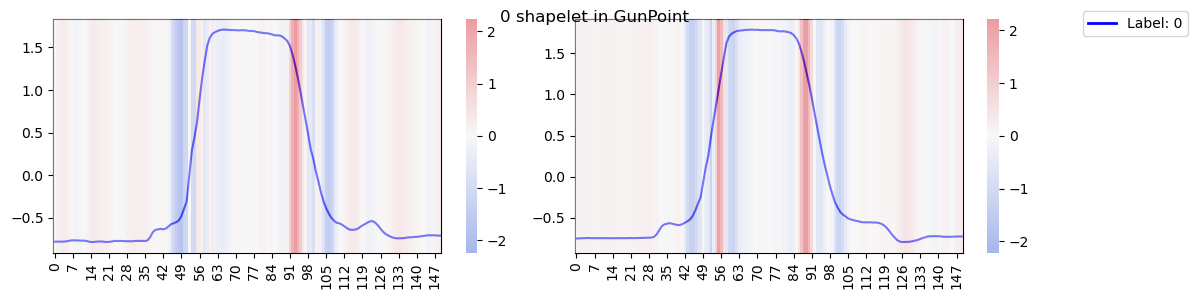

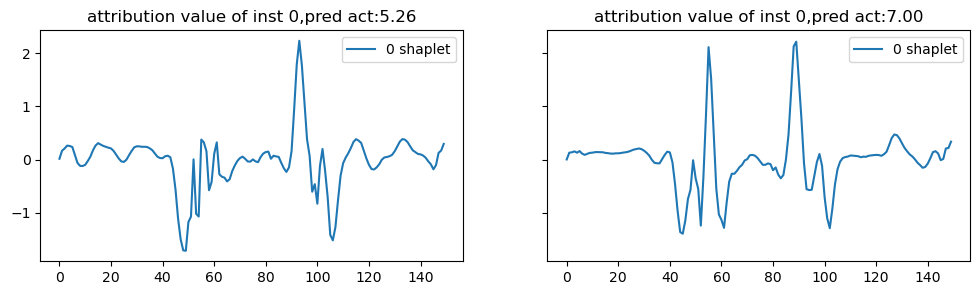

[-17.061485   9.704296]


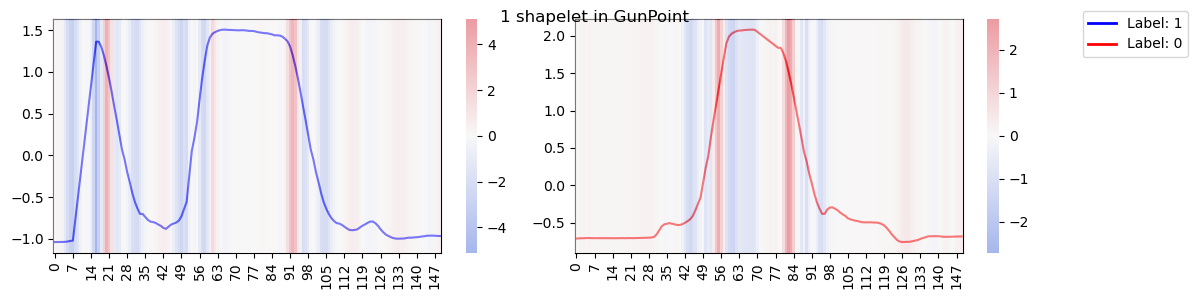

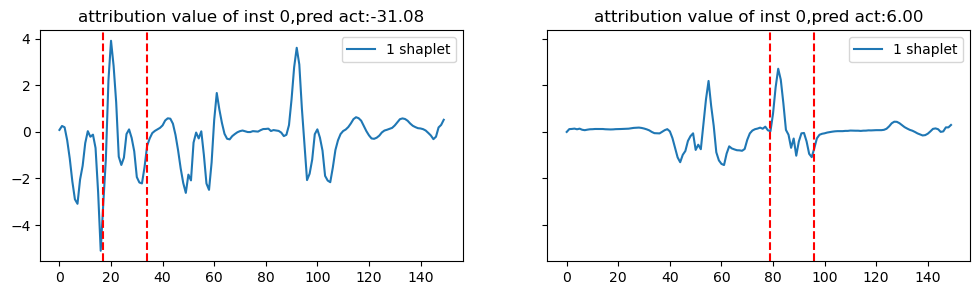

[-37.047623  24.923471]


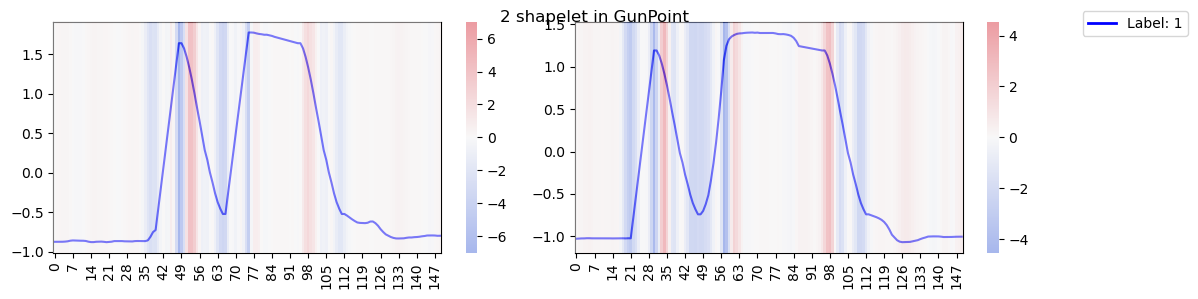

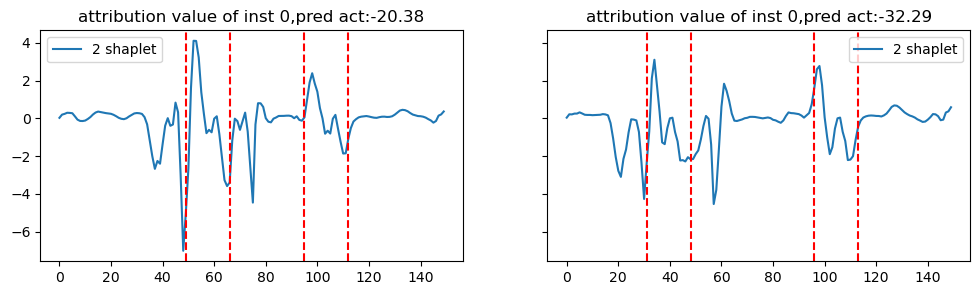

In [25]:
for i in range(3):
    path = f'probe/insert_implet_datasets_blending_10//{i}/'
    dataset = 'GunPoint'
    with open(path + f'DeepLift/{dataset}.pkl', 'rb') as f:
        ECG_attr = pickle.load(f)
        attr = ECG_attr['attributions']
    with open(path + f'{dataset}.pkl', 'rb') as f:
        ECG_inst = pickle.load(f)
        inst = ECG_inst['train_x']
        preds = ECG_inst['preds']
        startings = ECG_inst['startings']
        length = ECG_inst['length']
        print(np.mean(preds,axis=0))

    inst = inst[np.where(train_y==0)]
    preds = preds[np.where(train_y==0)]
    attr = attr[np.where(train_y==0)]
    startings = [startings[j] for j in range(len(startings)) if j in np.where(train_y==0)[0]]
    plot_multiple_images_with_attribution(inst, preds, 2, figsize=(12, 3), use_attribution=True,
                                              attributions=attr, normalize_attribution=True, title=f"{i} shapelet in {dataset}", save_path=None,
                                              test_y=None)
    fig,axs = plt.subplots(1,2,figsize=(12,3),sharey=True)
    for j in range(2):
        axs[j].plot(attr[j],label=f'{i} shaplet')
        
        axs[j].set_title(f'attribution value of inst 0,pred act:{np.array(preds[j][0]):.2f}')
        for starting in startings[j]:
           
            axs[j].axvline(starting,color='r',linestyle='--')
            axs[j].axvline(starting+length,color='r',linestyle='--')
        axs[j].legend()
    plt.show()

# insert with best location 

In [12]:
bg_per = get_bg_pred(model=model, selected_datasets=selected_datasets, 
            inst_length=inst_length, target_class=0, device='cuda')

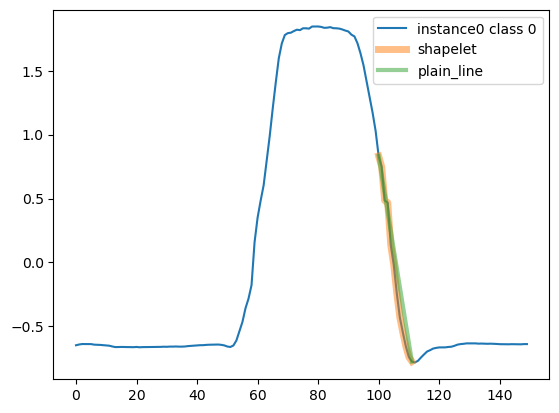

In [311]:
plain_line = np.linspace(shapelet[0],shapelet[-1],len(shapelet))
plt.plot(train_x[0].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(100,112),train_x[0,:,100:112].flatten(),
         linewidth=5,label='shapelet',alpha=0.5)
plt.plot(np.arange(100,112),plain_line,
         linewidth=3,label='plain_line',alpha=0.5)
plt.legend()

In [320]:
target_sample = torch.from_numpy(test_inst.reshape(1, -1, test_inst.shape[-1])).float().to(device)
target_label = torch.argmax(model(target_sample)).item()
print(target_label)

1


In [388]:
def generate_parabola(point_LHS, point_RHS,length):
    """
    Generate the coefficients of a parabola y = ax^2 + bx + c
    given two crossing points on the left-hand side (LHS) and right-hand side (RHS).
    
    Parameters:
    - point_LHS: tuple (y1), coordinates of the LHS crossing point
    - point_RHS: tuple (y2), coordinates of the RHS crossing point
    
    Returns:
    - a, b, c, shapelet: coefficients of the parabola and the final shapelet
    """
    y1 = point_LHS
    y2 = point_RHS
    x1 = 0
    x2 = length
    # Calculate the coefficients based on the equations
    a = (y2 - y1) / (x2**2 - x1**2)  # Coefficient a
    b = -2 * a * x1                  # Coefficient b (symmetry assumption)
    c = y1 - a * x1**2 - b * x1      # Coefficient c
    x = np.linspace(0, length,length)
    y = a * x**2 + b * x + c
    return a, b, c, y
shapelet = train_x[0,:,100:112].flatten()
a,b,c,subsequence = generate_parabola(shapelet[0],shapelet[-1],len(shapelet))

12


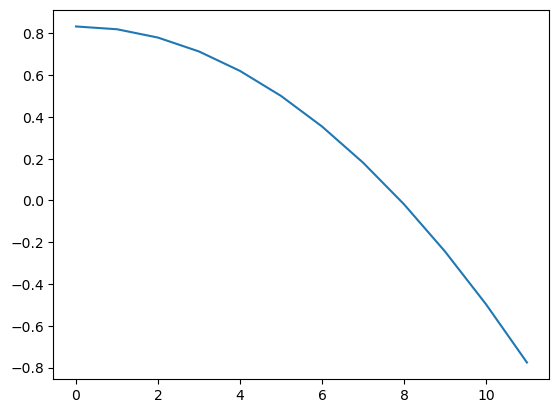

In [389]:
plt.plot(subsequence)

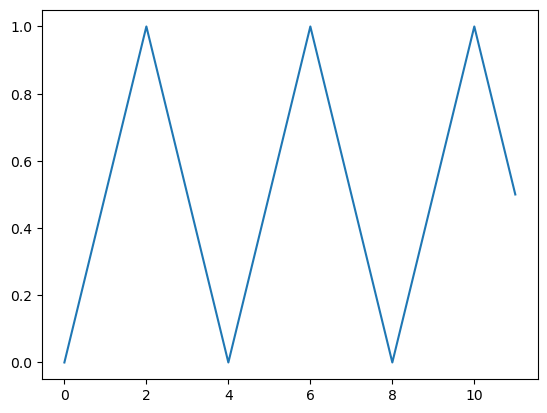

In [342]:
def create_1d_zigzag_array(seq_len, cycle_len):
    """
    Generate a zigzag pattern for a sequence.
    
    Parameters:
        seq_len (int): Total sequence length.
        cycle_len (int): Length of one zigzag cycle (up and down).
    
    Returns:
        np.ndarray: An array containing the zigzag pattern.
    """
    # Ensure cycle_len is at least 2 to create a zigzag pattern
    if cycle_len < 2:
        raise ValueError("cycle_len must be at least 2.")
    
    # Generate one cycle of the zigzag (up and down)
    half_cycle = cycle_len // 2
    upward = np.arange(half_cycle) / half_cycle  # e.g., [0, 1, 2, ...]
    downward = np.arange(half_cycle, 0, -1)  / half_cycle  # e.g., [2, 1]
    full_cycle = np.concatenate((upward, downward[:cycle_len - len(upward)]))
    
    # Tile the cycles to cover the full sequence length
    num_repeats = (seq_len + len(full_cycle) - 1) // len(full_cycle)
    zigzag = np.tile(full_cycle, num_repeats)[:seq_len]
    
    return zigzag

# Example: create a zigzag array of size 10
zigzag_array = create_1d_zigzag_array(12, 5)
plt.plot(zigzag_array)

In [7]:
import numpy as np
array_of_objects = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

# Convert to 2D NumPy array
array_2d = np.array(array_of_objects,dtype=object)

print(array_2d.shape)
type(array_2d)

(3, 3)


numpy.ndarray

18.59
[1] [1] [1]


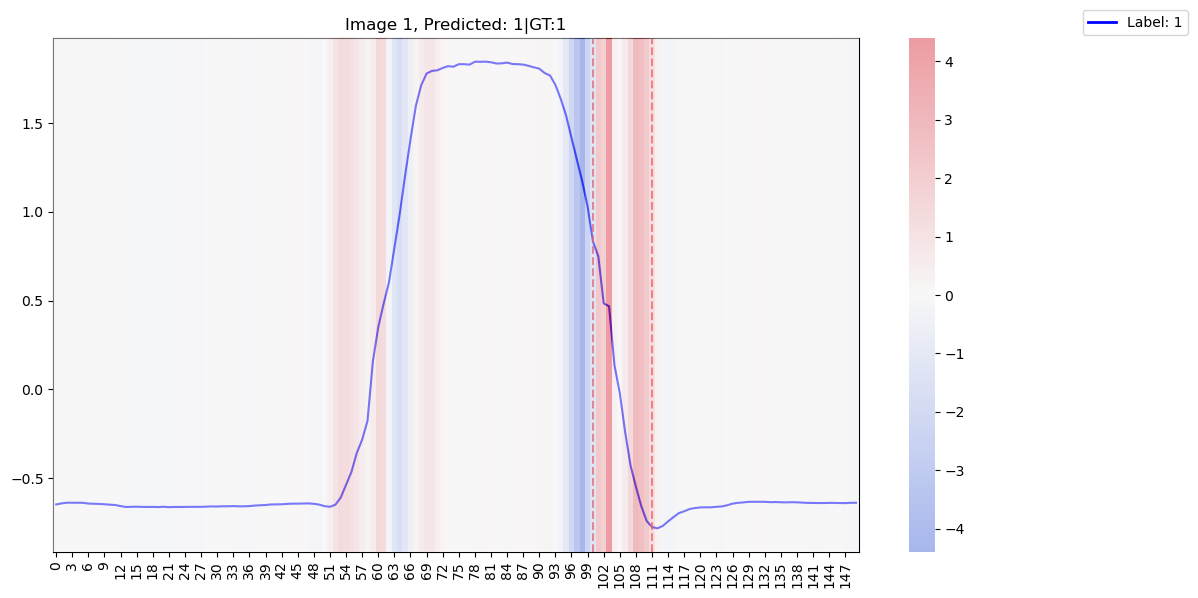

In [381]:
test_inst = train_x[0,:,:].copy()
test_inst[:,100:112] = subsequence #(plain_line - create_1d_zigzag_array(12, 12)*0.5).reshape(1,-1)
test_inst = test_inst.reshape(1,-1,150)
startings= [100]
attributions, attribution_shapelet = get_attr(model, test_inst, 
                                              [100], 12, None, xai_name='DeepLift', target_class=None, repeats=None,
                                              device='cuda')
print(f'{np.sum(attribution_shapelet):.2f}')
plot_multiple_images_with_attribution(test_inst, [target_label], 1, figsize=(12, 6), use_attribution=True,
                                      attributions=attributions, normalize_attribution=True, title="", save_path=None,
                                      test_y=[train_y[0]], attr_extremum=None, startings=[[100]], shapelet_length=12,
                                      is_title=True)


In [304]:
(shapelet[0] - shapelet[-1])/len(shapelet)

0.13400390333333334

In [299]:
shape_diff = 
print(shape_diff)

1.60804684


In [257]:
shapelet = train_x[0,:,100:112].flatten() #np.zeros(15)
selected_datasets = selected_uni
inst_length = 150
DF = pd.DataFrame({})
DF.index = selected_uni
DF['bg'] = bg_per.values()
xai_name = 'DeepLift'
i=1
save_dir = f'probe/insert_implet_datasets_best_c1/{i}'
dataset_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                             selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                             is_add=False,
                                                             xai_name=xai_name, num_attribution_each=None,
                                                             target_class=1, repeat_max=100,
                                                             is_z_norm=True, 
                                                             is_blending=False,
                                                             is_best_insert=True,
                                                             is_plot=False, is_verbose=False,
                                                             img_path=None,
                                                             save_dir=save_dir, device='cuda')
    
DF[f'insert_num_{i}'] = insert_shapelet_percentage.values()
DF

,bg,insert_num_0
ECG200,0.00,0.00
Beef,0.00,0.00
ElectricDevices,0.00,0.00
Earthquakes,0.00,0.00
Wafer,0.00,0.00
PowerCons,0.00,0.00
NonInvasiveFetalECGThorax1,0.00,0.00
ECG5000,0.00,0.00
GunPoint,0.48,0.48
HandOutlines,0.00,0.00


In [259]:
DF_act = pd.DataFrame({})
DF_act.index = selected_uni
for i in [0,1]:
    dataset_act = {}
    for dataset in selected_uni:
        
        if i ==0:
            path = f'probe/insert_implet_datasets_blending_10/0/'
        else:
            path = f'probe/insert_implet_datasets_best_c1/1/'
        
        with open(path + f'DeepLift/{dataset}.pkl', 'rb') as f:
            ECG_attr = pickle.load(f)
            attr = ECG_attr['attributions']
        with open(path + f'{dataset}.pkl', 'rb') as f:
            ECG_inst = pickle.load(f)
            inst = ECG_inst['train_x']
            preds = ECG_inst['preds']
            startings = ECG_inst['startings']
            length = ECG_inst['length']
        # print(f'{dataset},inserted shapelet num:{i}, activation of class 0: {np.mean(preds,axis=0)[0]:.2f}')
        dataset_act[dataset] = np.mean(preds,axis=0)[1].item()
    
    DF_act[f'num_insert_{i}'] = dataset_act
DF_act.columns = ['bg', 'best_insert']

DF_act['act_increase'] = DF_act['best_insert'] - DF_act['bg']
DF_act['increase_per'] = DF_act['act_increase'] / DF_act['best_insert'].abs()

DF_act = DF_act.round(2)
DF_act

,bg,best_insert,act_increase,increase_per
ECG200,48.25,42.82,-5.43,-0.13
Beef,58.23,46.87,-11.36,-0.24
ElectricDevices,123.12,98.66,-24.46,-0.25
Earthquakes,379.57,296.85,-82.72,-0.28
Wafer,79.17,67.77,-11.40,-0.17
PowerCons,121.33,113.09,-8.24,-0.07
NonInvasiveFetalECGThorax1,108.26,112.04,3.78,0.03
ECG5000,61.21,56.61,-4.60,-0.08
GunPoint,-0.68,-0.26,0.43,1.67
HandOutlines,38.59,41.44,2.85,0.07


In [251]:
import torch.nn as nn
m = nn.Softmax(dim=1)
dataset_preds = {}
for dataset in selected_uni:
    dataset_pred = []
    for i in [0,1]:
        if i ==0:
            path = f'probe/insert_implet_datasets_blending_10/0/'
        else:
            path = f'probe/insert_implet_datasets_best_c1/1/'   
        with open(path + f'{dataset}.pkl', 'rb') as f:
            restults_probe = pickle.load(f)
            
            preds = restults_probe['preds']
            # preds = m(torch.from_numpy(preds)).numpy()
        dataset_pred.append(preds[:,1])
        
    dataset_preds[dataset] = dataset_pred
# dataset_preds

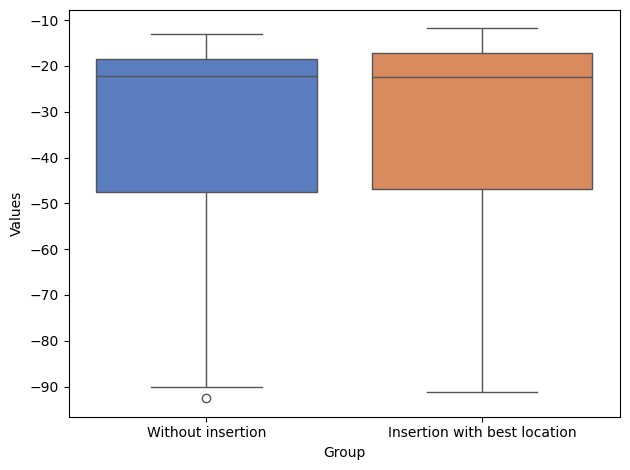

In [222]:
dataset_show = dataset_preds.copy()
pd_all = []

for i, (dataset_name, dataset_pred) in enumerate(dataset_show.items()):
    
    data = pd.DataFrame({
        "Values": np.concatenate(dataset_pred),
        "Group": np.repeat(["Without insertion","Insertion with best location"], 
                           [len(arr) for arr in dataset_pred])
    })
    pd_all.append(data)
    # sns.boxplot(ax=axes[i], x="Group", y="Values", data=data, palette="muted")
    
    # # 设置标题和标签
    # axes[i].set_title(f"Box Plot of activation distribution of {dataset_name}", fontsize=16)
    # axes[i].set_xlabel("Distributions", fontsize=12)
    # axes[i].set_ylabel("probablity w.r.t class 0", fontsize=12)
    # axes[i].tick_params(axis='x', rotation=45) 
    # # 显示图像

sns.boxplot(x="Group", y="Values", data=data, palette="muted")
plt.tight_layout()
# plt.savefig('figure/Box_plot_insertion_activation_non_feature.png')

(5, 4)


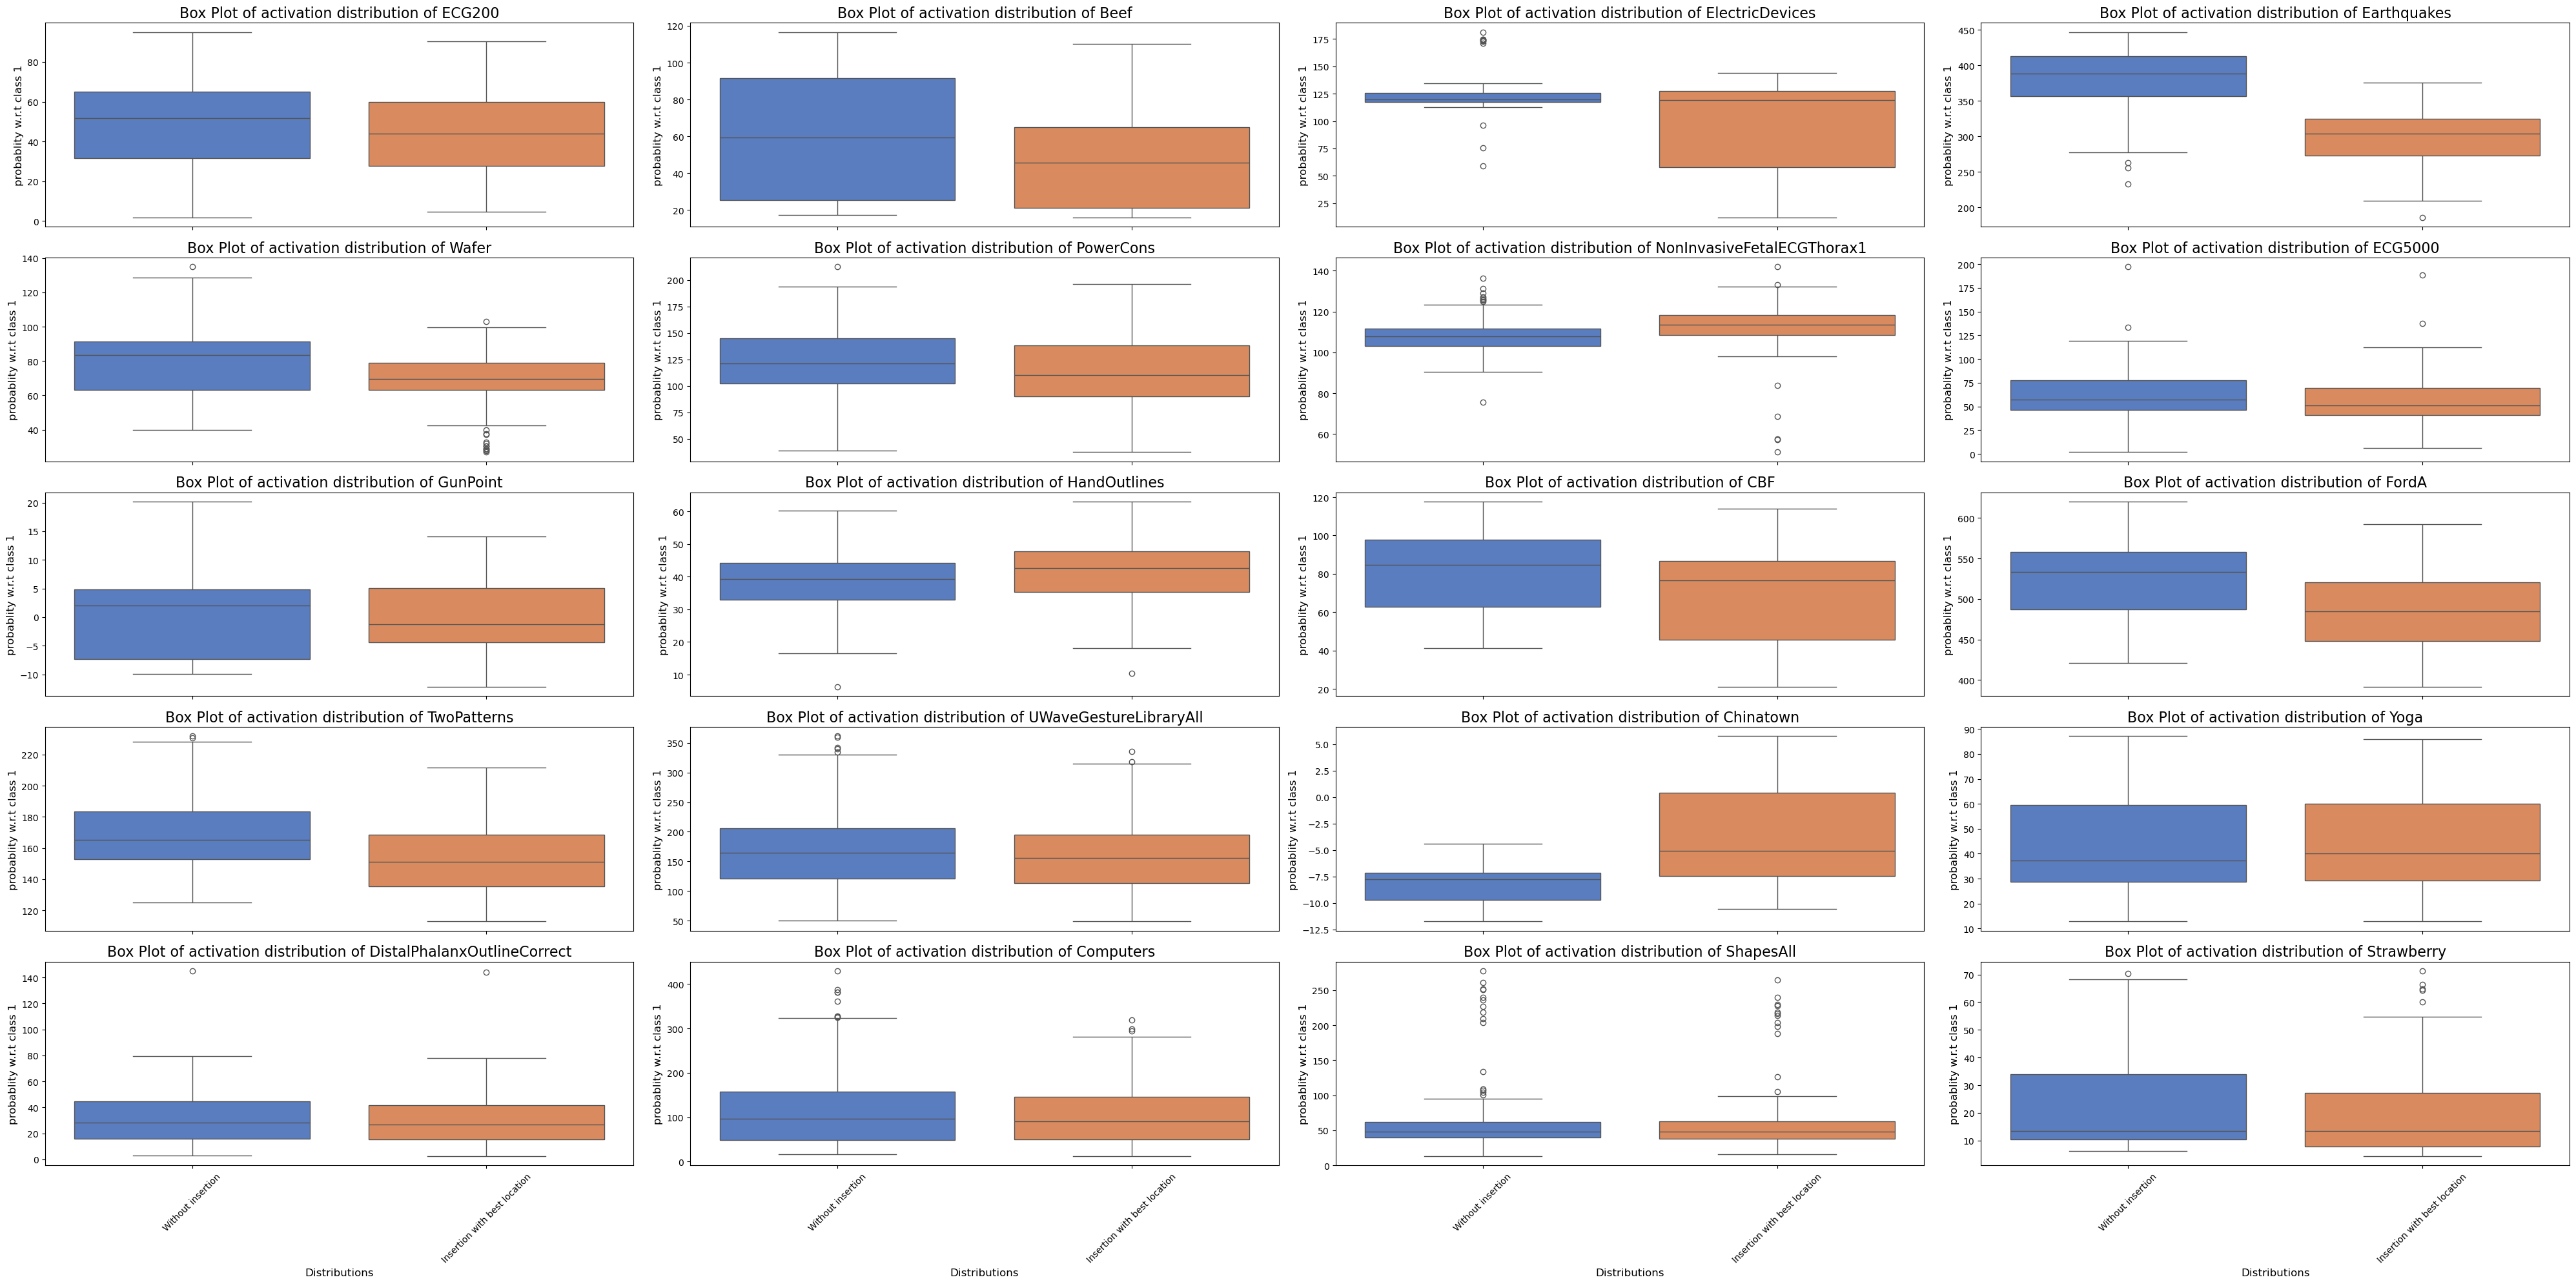

In [252]:
dataset_show = dataset_preds.copy()
# dataset_show = {}
# dataset_show['ElectricDevices'] = dataset_preds['ElectricDevices']
n_subplots = len(dataset_show)
num_rol_col = math.ceil(math.sqrt(n_subplots))
shape = (num_rol_col, math.ceil(n_subplots / num_rol_col))
print(shape)
figsize = (8*num_rol_col, 5*math.ceil(n_subplots / num_rol_col))
fig, axes = plt.subplots(shape[0], shape[1], figsize=figsize, sharex=True)
if n_subplots == 1:
    axes = [axes]
else:
    axes = axes.flatten()  

pd_all = []

for i, (dataset_name, dataset_pred) in enumerate(dataset_show.items()):
    
    data = pd.DataFrame({
        "Values": np.concatenate(dataset_pred),
        "Group": np.repeat(["Without insertion","Insertion with best location"], 
                           [len(arr) for arr in dataset_pred])
    })
    sns.boxplot(ax=axes[i], x="Group", y="Values", data=data, palette="muted")
    
    # 设置标题和标签
    axes[i].set_title(f"Box Plot of activation distribution of {dataset_name}", fontsize=16)
    axes[i].set_xlabel("Distributions", fontsize=12)
    axes[i].set_ylabel("probablity w.r.t class 1", fontsize=12)
    axes[i].tick_params(axis='x', rotation=45) 
    # 显示图像
plt.tight_layout()
plt.savefig('figure/Box_plot_insertion_activation_c1_a1.png')


# visualization

[[-477.3191   387.69586]
 [-453.0136   366.4784 ]
 [-318.04904  255.69371]
 [-481.15695  388.49753]]


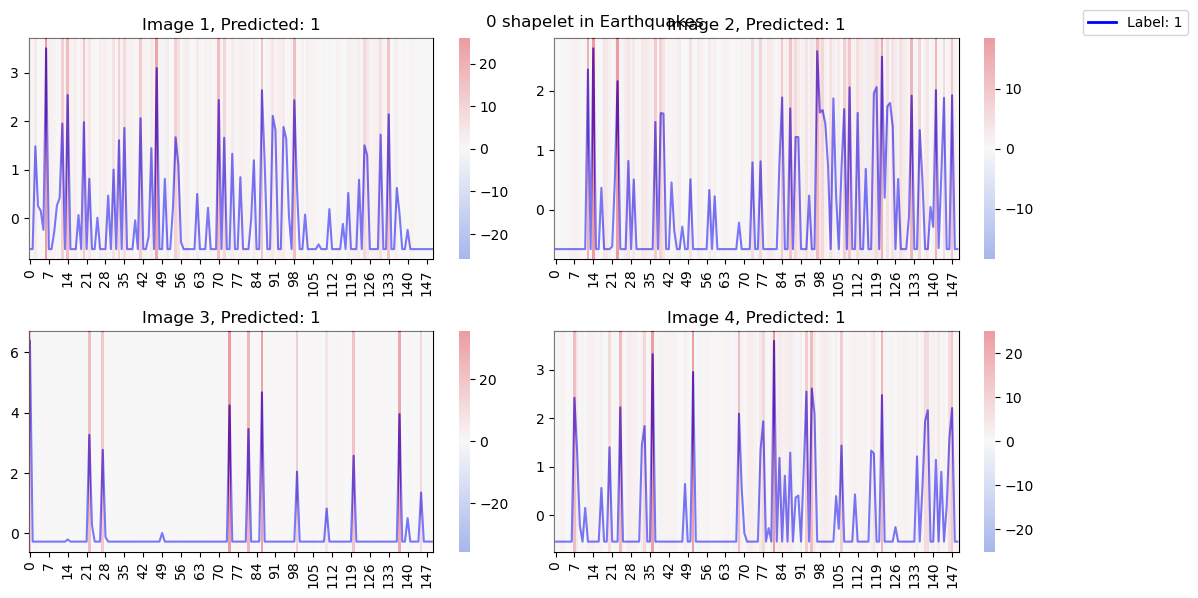

[[-371.585    301.05627]
 [-368.26855  296.8756 ]
 [-231.59047  185.99234]
 [-392.8353   316.28253]]


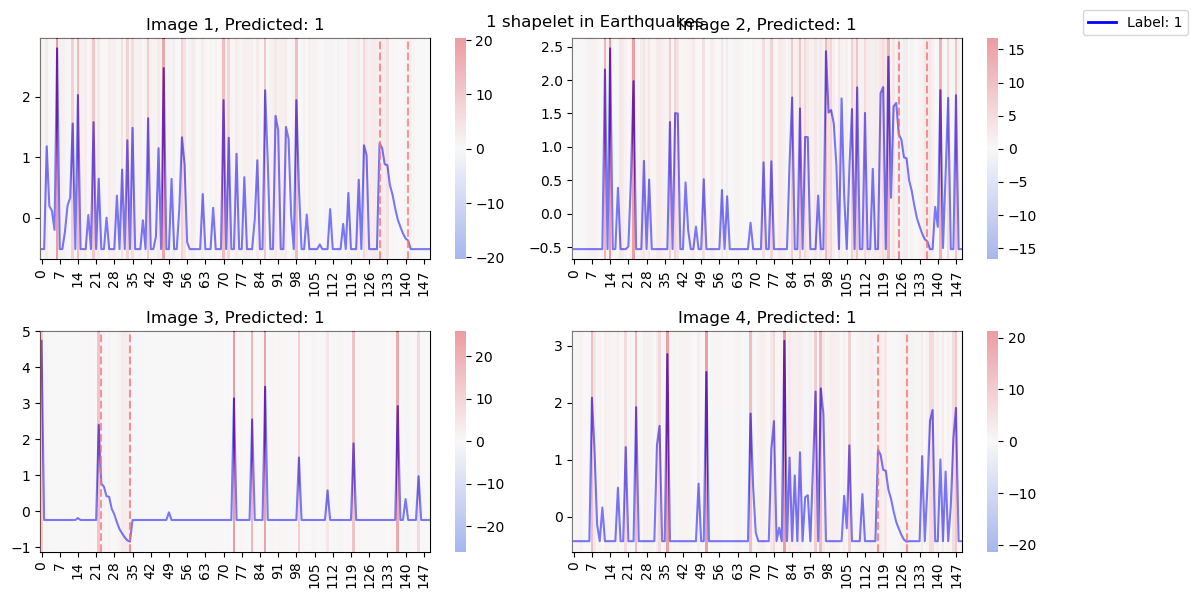

In [261]:
dataset = 'Earthquakes'
for i in [0,1]:
    if i ==0:
        path = f'probe/insert_implet_datasets_blending_10/0/'
    else:
        path = f'probe/insert_implet_datasets_best_c1/1/'
    
    with open(path + f'DeepLift/{dataset}.pkl', 'rb') as f:
        ECG_attr = pickle.load(f)
        attr = ECG_attr['attributions']
    with open(path + f'{dataset}.pkl', 'rb') as f:
        ECG_inst = pickle.load(f)
        inst = ECG_inst['train_x']
        preds = ECG_inst['preds']
        startings = ECG_inst['startings']
        length = ECG_inst['length']
        
    if dataset == 'GunPoint':
        inst = inst[np.where(train_y==0)]
        preds = preds[np.where(train_y==0)]
        attr = attr[np.where(train_y==0)]
        startings = [startings[j] for j in range(len(startings)) if j in np.where(train_y==0)[0]]
    
    indices = [0 ,3, 5, 6]
    inst = inst[indices]
    preds = preds[indices]
    attr = attr[indices]
    startings = [startings[j] for j in range(len(startings)) if j in indices]
    
    # print(np.mean(preds,axis=0))
    print(preds)
    
    plot_multiple_images_with_attribution(inst, preds, 4, use_attribution=True,
                                              attributions=attr, normalize_attribution=True, title=f"{i} shapelet in {dataset}", save_path=None,
                                              test_y=None,startings=startings,shapelet_length=length)


In [60]:
for i in range(length):
    print(inst[1,:,119+i])

[0.99306929]
[0.93110632]
[0.82940251]
[0.70322244]
[0.55955714]
[0.39777135]
[0.22542781]
[0.06132958]
[-0.11601019]
[-0.28704275]
[-0.4033845]
[-0.553854]
[-0.67302856]
[-0.80410561]
[-0.90979382]
[-0.98706501]
[-1.05065096]
[1.29420532]
2.0193931


In [82]:
print(inst[1,:,118] - inst[1,:,119+length])
print(inst_bg[1,:,119] - inst_bg[1,:,119+length-1])
print(shapelet[0] - shapelet[-1])

[1.27879992]
[1.18084958]
2.0193931


In [54]:
startings[1]

[119]

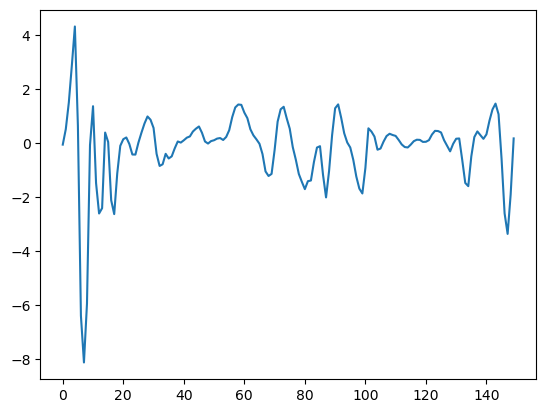

In [72]:
with open('probe/insert_shapelet_datasets/1/DeepLift/ECG200.pkl', 'rb') as f:
    ECG_1_shape = pickle.load(f)
    attr = ECG_1_shape['attributions']
plt.plot(attr[0])

## Now we have only the positive attribution parts

In [99]:
with open('attributions/GunPoint/DeepLift/train_exp.pkl', 'rb') as f:
    attr = pickle.load(f)
attr_gp = attr['attributions']

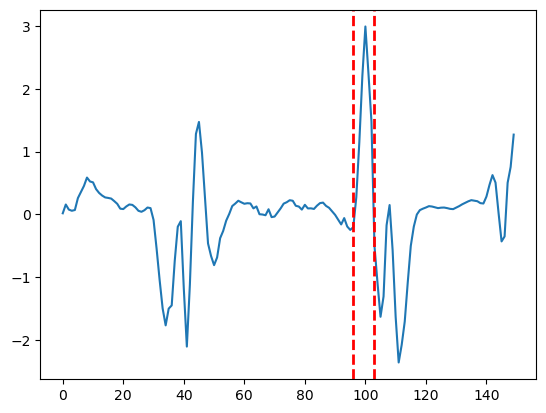

In [110]:
plt.plot(attr_gp[0])
plt.axvline(x=96, color='r', linestyle='--', linewidth=2)
plt.axvline(x=103, color='r', linestyle='--', linewidth=2)

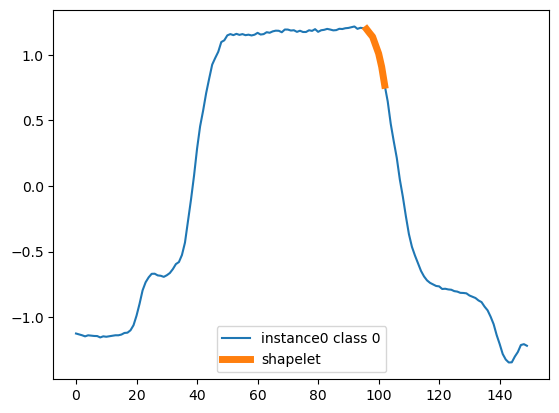

In [111]:
plt.plot(test_x[0].flatten(),label=f'instance{0} class {test_y[0]}')
plt.plot(np.arange(96,103),test_x[0,:,96:103].flatten(),
         linewidth=5,label='shapelet')
plt.legend()
# plt.plot(test_x[0,:,30:55].flatten())

In [143]:
shapelet = test_x[0,:,96:103].flatten()
length = len(shapelet)
shapelet_distances_train, info_gain, best_threshold = get_distances_info_gain(dataset=train_x, shapelet=shapelet, length=length, pos=96, labels=train_y)


In [134]:
from utils.shapelet import compute_shapelet_distance

In [139]:
compute_shapelet_distance(test_x[0], shapelet, length=length, position=96)


0.0 96


In [140]:
shapelet_distances_test, info_gain, best_threshold = get_distances_info_gain(dataset=test_x, shapelet=shapelet, length=length, pos=96, labels=test_y)
print(info_gain)

0.06566781650220332


In [141]:
from sklearn.metrics import (
    accuracy_score,
)
from sklearn.linear_model import LinearRegression

In [146]:
shapelet_distances_train = shapelet_distances_train.reshape(-1, 1)
shapelet_distances_test = shapelet_distances_test.reshape(-1, 1)

classifier = LinearRegression()
classifier.fit(shapelet_distances_train, train_y)
train_pred = classifier.predict(shapelet_distances_train)
train_pred[train_pred < 0.5] = 0
train_pred[train_pred >= 0.5] = 1

test_pred = classifier.predict(shapelet_distances_test)
test_pred[test_pred < 0.5] = 0
test_pred[test_pred >= 0.5] = 1

print(f'Training Accuracy = {accuracy_score(train_y, train_pred):.2f}')
print(f'Testing Accuracy = {accuracy_score(test_y, test_pred):.2f}')

Training Accuracy = 0.50
Testing Accuracy = 0.55


In [59]:
from utils.insert_shapelet import insert_data_to_env,get_bg_pred
from utils.constants import selected_uni
import pandas as pd
from utils.visualization import plot_multiple_images_with_attribution
from utils import *

In [63]:
inst_length = 150
bg_per = get_bg_pred(model=model, selected_datasets=selected_uni, 
            inst_length=inst_length, target_class=0, device='cuda')

In [64]:
bg_per

{'ECG200': 0.0,
 'Beef': 0.0,
 'ElectricDevices': 0.0,
 'Earthquakes': 0.0,
 'Wafer': 0.0,
 'PowerCons': 0.0,
 'NonInvasiveFetalECGThorax1': 0.0,
 'ECG5000': 0.0,
 'GunPoint': 0.48,
 'HandOutlines': 0.0,
 'CBF': 0.0,
 'FordA': 0.0,
 'TwoPatterns': 0.0,
 'UWaveGestureLibraryAll': 0.0,
 'Chinatown': 1.0,
 'Yoga': 0.0,
 'DistalPhalanxOutlineCorrect': 0.0,
 'Computers': 0.0,
 'ShapesAll': 0.0,
 'Strawberry': 0.0}

In [65]:
shapelet = test_x[0,:,96:103].flatten()
selected_datasets = selected_uni
inst_length = 150
DF = pd.DataFrame({})
DF.index = selected_uni
DF['bg'] = bg_per.values()
for i in range(1,4):
    save_dir = f'probe/insert_shapelet_2/{i}'
    dataset_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                    xai_name=None, num_attribution_each=None,
                                                                    target_class=0, repeat_max=100,
                                                                    is_z_norm=True, is_plot=False, is_verbose=False,
                                                                    img_path=None,
                                                                    save_dir=save_dir, device='cuda')
    
    DF[f'insert_num_{i}'] = insert_shapelet_percentage.values()
DF

,bg,insert_num_1,insert_num_2,insert_num_3
ECG200,0.00,0.00,0.00,0.00
Beef,0.00,0.00,0.00,0.00
ElectricDevices,0.00,0.00,0.00,0.00
Earthquakes,0.00,0.00,0.00,0.00
Wafer,0.00,0.00,0.00,0.00
PowerCons,0.00,0.00,0.00,0.00
NonInvasiveFetalECGThorax1,0.00,0.00,0.00,0.00
ECG5000,0.00,0.00,0.00,0.00
GunPoint,0.48,0.16,0.06,0.02
HandOutlines,0.00,0.00,0.00,0.00


In [122]:
for i in range(4):
    shapelet = test_x[0,:,96:103].flatten()
    save_dir = f'probe/insert_shapelet_2/{i}'
    deeplift_attr, insert_shapelet_percentage = insert_data_to_env(model=model, shapelet=shapelet, 
                                                                 selected_datasets=selected_datasets, inst_length=inst_length, num_shapelet=i, 
                                                                 is_add=False,
                                                                 xai_name='DeepLift', num_attribution_each=None,
                                                                 target_class=0, repeat_max=100,
                                                                 is_z_norm=True, is_plot=False, is_verbose=False,
                                                                 img_path=None,
                                                                 save_dir=save_dir, device='cuda')

[[ -21.557827   13.57855 ]
 [-123.12366    95.04367 ]]


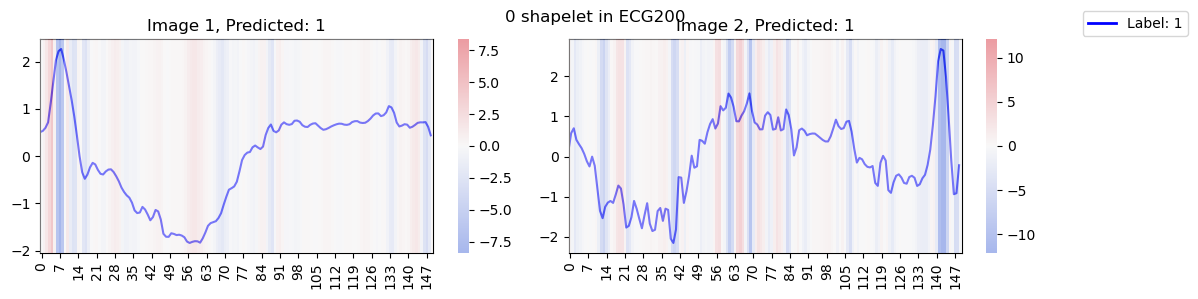

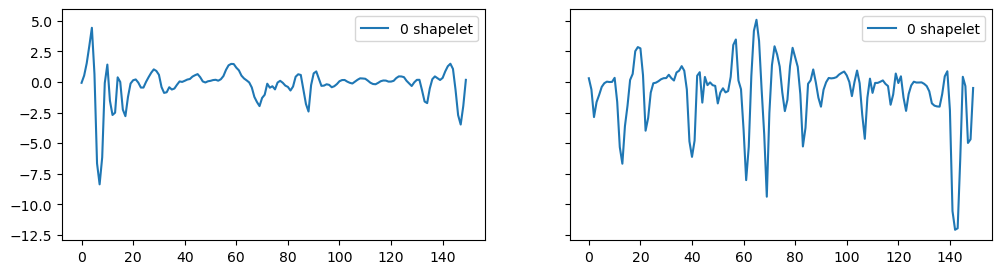

[[ -55.857582   41.435463]
 [-118.98994    91.73128 ]]


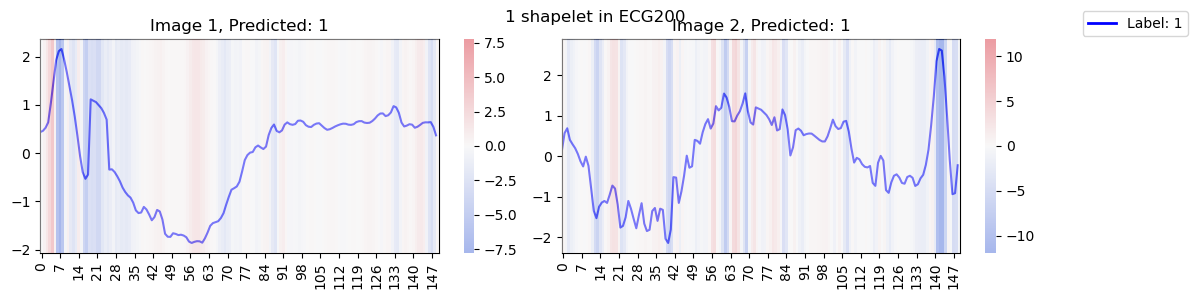

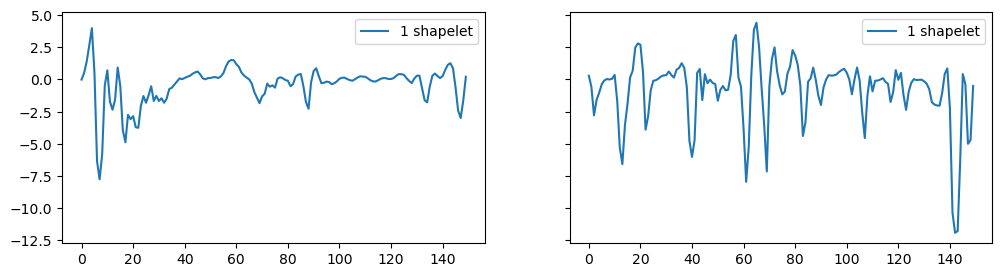

[[-218.52754  173.56636]
 [-256.20377  203.52669]]


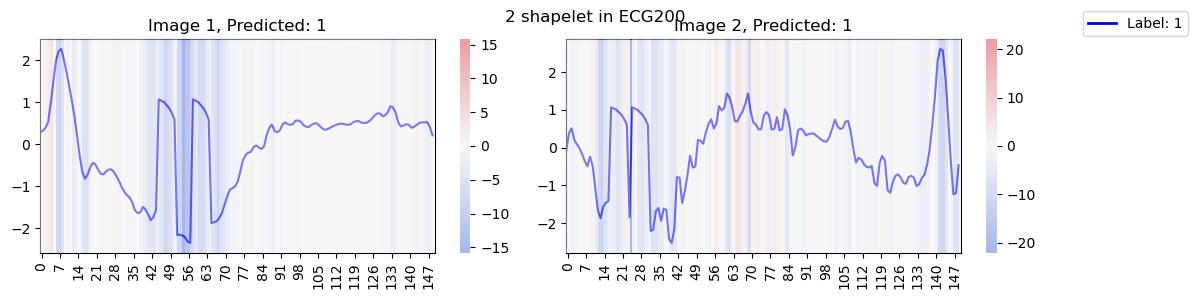

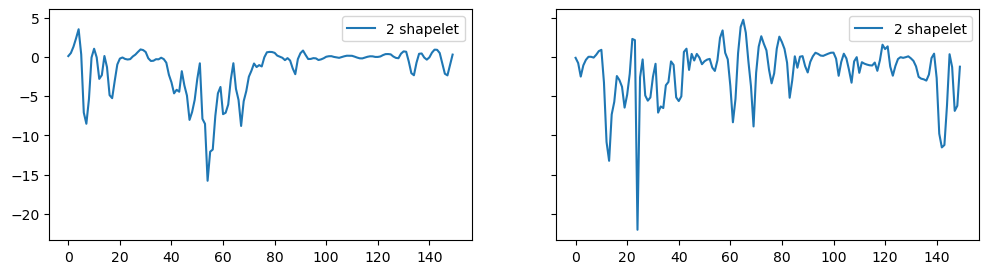

[[ -62.528698   46.191998]
 [-240.84044   191.04712 ]]


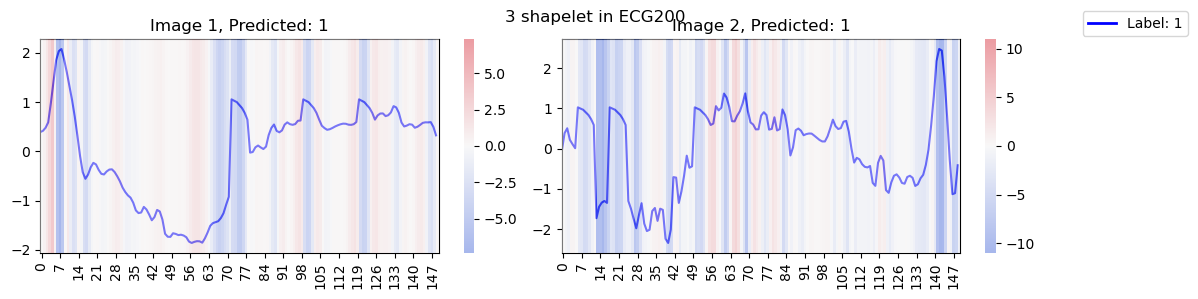

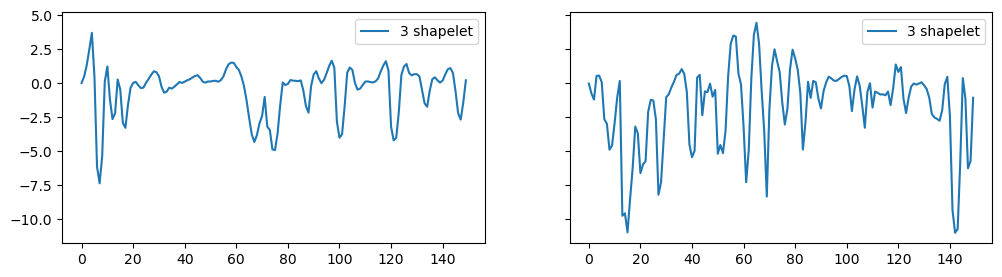

In [10]:
for i in range(4):
    path = f'probe/insert_shapelet_2/{i}/'
    with open(path + 'DeepLift/ECG200.pkl', 'rb') as f:
        ECG_attr = pickle.load(f)
        attr = ECG_attr['attributions']
    with open(path + 'ECG200.pkl', 'rb') as f:
        ECG_inst = pickle.load(f)
        inst = ECG_inst['train_x']
        preds = ECG_inst['preds']
        print(preds[0:2])
    plot_multiple_images_with_attribution(inst, preds, 2, (1,2), figsize=(12, 3), use_attribution=True,
                                              attributions=attr, normalize_attribution=True, title=f"{i} shapelet in ECG200", save_path=None,
                                              test_y=None)
    fig,axs = plt.subplots(1,2,figsize=(12,3),sharey=True)
    axs[0].plot(attr[0],label=f'{i} shapelet')
    axs[0].legend()
    axs[1].plot(attr[1],label=f'{i} shapelet')
    axs[1].legend()
    plt.show()

In [80]:
len(inst[0].flatten())

array([ 5.08089270e-01,  5.33862159e-01,  5.98493171e-01,  7.14303174e-01,
        1.12202315e+00,  1.57623535e+00,  2.03095916e+00,  2.22291467e+00,
        2.26618893e+00,  2.04457187e+00,  1.77654911e+00,  1.47630737e+00,
        1.18068227e+00,  8.36041813e-01,  4.32126977e-01,  6.55263958e-04,
       -3.41096578e-01, -4.80636650e-01, -3.91845577e-01, -2.38503042e-01,
       -1.43114035e-01, -1.76825760e-01, -2.91530057e-01, -3.75185376e-01,
       -3.89126821e-01, -3.25608405e-01, -2.85394639e-01, -2.79820203e-01,
       -3.37640442e-01, -4.27631089e-01, -5.33777932e-01, -6.65768790e-01,
       -7.60271671e-01, -8.31394722e-01, -8.80092096e-01, -9.85527194e-01,
       -1.14890720e+00, -1.20611391e+00, -1.19470666e+00, -1.07535029e+00,
       -1.13034826e+00, -1.23641802e+00, -1.35861732e+00, -1.29115125e+00,
       -1.13960934e+00, -1.17158405e+00, -1.34264930e+00, -1.64428934e+00,
       -1.70722597e+00, -1.70929266e+00, -1.63333406e+00, -1.64729242e+00,
       -1.67191487e+00, -